In [1]:
"""
Created on 30/12/2024

@author: Federica Montana

This file contains additional analyses and sensitivity analysis using external datasets. In particular, it contains the following steps:
1. Correlation and sensitivity analysis between the permeability indicator and green spaces data (external data)
2. Sensitivity analysis changing the target in the opportunity to walk and to cycle indicators
3. Correlation analysis bewteern air quality (PM2.5 and NO2) and external datasets (airbase datset)

"""
# Import packages
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from utility import clusters, domains, indicators, statistics, dom_ind_dict


## Permeability

In [2]:
## Correlation of imd data (permeability) with green data
#  Green Domain - Grid Level
df_green0 = pd.read_csv('DATA\\external_dataset\df_green.csv')
# Permeability indicator - Grid Level
df_imd2 = pd.read_csv('DATA\\data\df_imd.csv')
# Merge the two dataframes
merged_df = pd.merge(df_imd2[['gid','urau_code','val_grid']], df_green0, on=['gid','urau_code'], how='inner')
# Spearman correlation and p-value 
spearman_corr, spearman_p = stats.spearmanr(merged_df['val_grid'], merged_df['percGS300'])
spearman_corr

0.7936966370089452

In [3]:
# Create df_green 
df_pop = pd.read_csv('DATA\\data\\grid_pop.csv')
df_green = pd.merge(df_green0, df_pop[['gid','urau_code','cluster']], on=['gid','urau_code'], how='inner')
df_green.rename(columns={'percGS300': 'val_grid'}, inplace=True)

In [4]:
# Sensitivity using green spaces dataset
"""
Calculate the permeability indicator for each city at 250m resolution and city level
Columns of df_green:
- gid: Unique identifier for each row.
- pop_final: Population count.
- urau_code: Unique identifier for each urban area.
- urau_name: Name of the urban area.
- cluster: Cluster to which the urban area belongs.
- percGS300: Numeric values containing percentage of permeability data.
"""
df = df_green[['gid','urau_code', 'val_grid', 'pop_final', 'urau_name', 'cluster']]
# Set the thresholds for rescaling
threshold = 25
# Set the new target value in the scale [0-10]
new_target = 6

for cluster in clusters:
    df_imd = df[df.cluster == cluster]
    # Grids
    # If values higher than threshold rescaled in [10-6], otherwise [5-0]
    df1 = df_imd.copy()
    MIN = df1['val_grid'].min()
    MAX = df1['val_grid'].max()
    # Apply interpolation for each range
    df1['rescaled_grid'] = np.where(
        df1['val_grid'] <= threshold,
        np.interp(df1['val_grid'], [MIN, threshold], [0, new_target]),
        np.interp(df1['val_grid'], [threshold, MAX], [new_target, 10])
    )
    # Save data
    df1.to_csv(f'DATA/new_data\\{cluster}\\grid\\Urban Design_Permeability_SA.csv', index=False)

    # City
    df2 = df_imd.copy()
    df2['target'] = 0  # Initialize the column with default value 0
    df2.loc[df2['val_grid'] > 25, 'target'] = 1
    df2 = df2.copy()
    # Calculate the percentage of people meeting the grid permeability threshold
    df2['pop_target'] = df2['pop_final']*df2['target']
    df2['pop_sum_when_target_1'] = df2.groupby('urau_code')['pop_target'].transform('sum')
    df2['sum_pop'] = df2.groupby('urau_code')['pop_final'].transform('sum')
    df2['val_city'] = df2['pop_sum_when_target_1']/df2['sum_pop']*100
    # Rescale the values to the range [0-10]
    df2['rescaled_city'] = df2['val_city']/10 
    # Take the city just once
    df2 = df2.drop_duplicates('urau_code')
    df2 = df2[['gid','urau_code','urau_name', 'pop_final', 'val_city','rescaled_city','cluster']]

    df2.to_csv(f'DATA/new_data\\{cluster}\\city\\Urban Design_Permeability_SA.csv', index=False)

In [5]:
# Urban Design Domain - Grid Level
dfs = []
# Exclude Compactness indicator whic is not available at grid level
indicator_city =  indicators[3]
domain = domains[0]
scales = ['city','grid']
for scale in scales:
    # Read Permeability indicator
    for cluster in clusters:
        folder_path = f'DATA\\new_data\\{cluster}\\{scale}'
        filename = f'{domain}_{indicator_city}.csv'
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        df['indicator'] = indicator_city
        df['domain'] = domain
        dfs.append(df)
        #print(f'{cluster} and {indicator}:{len(df.urau_code.unique())}')
    if scale == 'grid':
        df1_grid = pd.concat(dfs, ignore_index=True)
    else:
        df1_city = pd.concat(dfs, ignore_index=True)              


    dfs2 = []
    # Read Green indicator
    for cluster in clusters:
        folder_path = f'DATA\\new_data\\{cluster}\\{scale}'
        filename = f'{domain}_{indicator_city}_SA.csv'
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        df['indicator'] = indicator_city
        df['domain'] = domain
        dfs2.append(df)
        #print(f'{cluster} and {indicator}:{len(df.urau_code.unique())}')
                
    if scale == 'grid':
        df2_grid = pd.concat(dfs2, ignore_index=True)
    else:
        df2_city = pd.concat(dfs2, ignore_index=True)  


In [6]:
statistics(df2_grid,'val_grid','green')

,Variable,Cluster,Mean,Std,25%,75%,Max,Min
0,green,Large metropolitan,25.10,21.94,7.16,38.40,96.32,0.0
1,green,Medium,37.16,25.27,14.93,57.40,100.00,0.0
2,green,Metropolitan,31.12,23.54,11.10,48.05,98.20,0.0
3,green,Small,42.15,26.42,18.60,64.53,100.00,0.0
4,green,Small towns,37.09,24.37,16.00,56.50,96.50,0.0


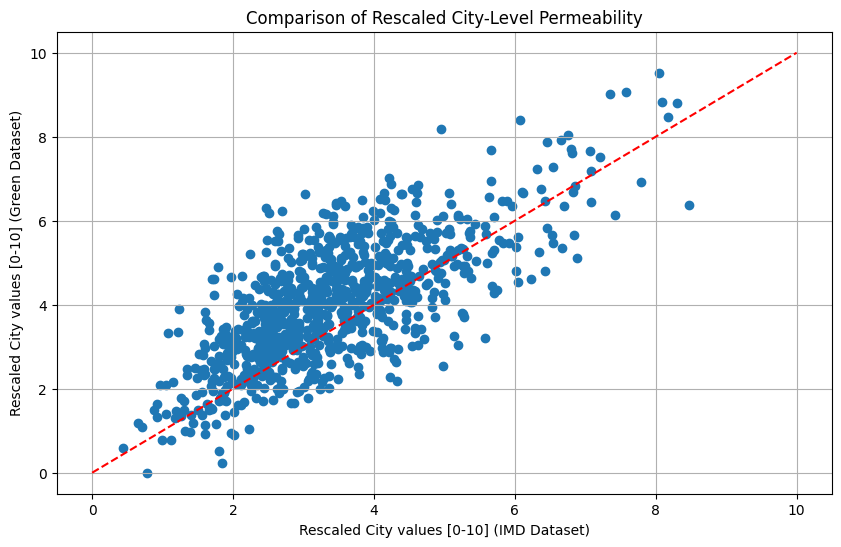

In [7]:
# Prepare data for Scatter plot - City level 
#  Merge on urau_code
df_compare1 = pd.merge(df1_city, df2_city[['urau_code','rescaled_city']], on='urau_code', suffixes=('_1', '_2'))

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_compare1['rescaled_city_1'], df_compare1['rescaled_city_2'])
plt.plot([0, 10], [0, 10], 'r--')  # Reference line for equality
plt.title('Comparison of Rescaled City-Level Permeability')
plt.xlabel('Rescaled City values [0-10] (IMD Dataset)')
plt.ylabel('Rescaled City values [0-10] (Green Dataset)')
plt.grid(True)
plt.savefig(f'plots\\indicators\\SA_permeability2_{scale}.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
spearman_corr, spearman_p = stats.spearmanr(df_compare1['rescaled_city_1'], 
                                            df_compare1['rescaled_city_2'])

spearman_corr

0.676717468546804

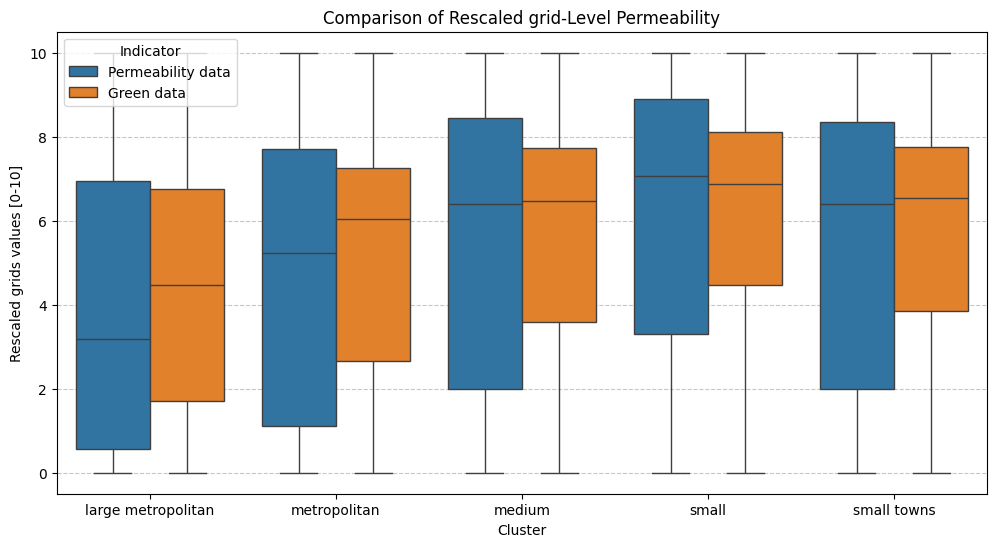

In [9]:
# Prepare data for box plot - GRID LEVEL
df_compare2 = pd.merge(df1_grid, df2_grid[['urau_code','gid','rescaled_grid']], on=['urau_code','gid'], suffixes=('_1', '_2'))
df_melted = pd.melt(df_compare2, id_vars=['urau_code', 'cluster'], 
                    value_vars=['rescaled_grid_1', 'rescaled_grid_2'], 
                    var_name='Indicator', value_name='Rescaled grids')
df_melted['Indicator'] = df_melted['Indicator'].replace({
    'rescaled_grid_1': 'Permeability data',
    'rescaled_grid_2': 'Green data'
})
# Box plot divided by cluster
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x='cluster', y='Rescaled grids', hue='Indicator')
#plt.title('Comparison of Rescaled grid-level Permeability by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Rescaled grids values [0-10]')
plt.legend(title='Indicator', loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.title('Comparison of Rescaled grid-Level Permeability')
plt.savefig(f'plots\\indicators\\SA_permeability2_grid.png', dpi=300, bbox_inches='tight')
plt.show()

### Opportunity to walk

In [10]:
"""
Calculate the opportunity to walk indicator for each city at 250m resolution and city level
Columns of df_cycl:
- gid: Unique identifier for each row.
- pop_final: Population count.
- urau_code: Unique identifier for each urban area.
- urau_name: Name of the urban area.
- cluster: Cluster to which the urban area belongs.
- val_grid: Numeric values containing % pedestrian infrastructure.
"""
df = pd.read_csv(f'DATA/data/df_walk.csv')
MAX_alls = [50,60,70]
for MAX_all in MAX_alls:
    for cluster in clusters:

        df2 = df[df.cluster == cluster]
        df2 = df2.copy()
        #City -- POPULATION WEIGHTED OPTIONS 
        df3 = (df2.groupby('urau_code').apply(lambda x: (x['pop_final'] * x['val_grid']).sum()) / 
                df2.groupby('urau_code')['pop_final'].sum()).reset_index(name='val_city').merge(df2, 
                                                                                                            on='urau_code', how='inner')

        df3 = df3.drop_duplicates(subset=['urau_code'])
        df3 = df3.copy()
        df3[f'rescaled_city_{MAX_all}'] = df3['val_city'].apply(
            lambda x: 10 if x > MAX_all else (np.sqrt(x) / np.sqrt(MAX_all)) * 10)   
        df3 = df3[['gid','urau_code','urau_name', 'pop_final', 'val_city', f'rescaled_city_{MAX_all}','cluster']]
        df3.to_csv(f'DATA/new_data\\{cluster}\\city\Sustainable Transportation_Opportunity to walk_{MAX_all}.csv', index=False) 


In [11]:
# Load indicator data created in the 3_indicators_analysis.py script
# Urban Design Domain - Grid Level
dfs = []
# Exclude Compactness indicator whic is not available at grid level
indicator_city =  indicators[4]
domain = domains[1]
scale = 'city'
targets = MAX_alls
for target in targets:
    dfs = []  
    # Read Permeability indicator
    for cluster in clusters:
        folder_path = f'DATA\\new_data\\{cluster}\\{scale}'
        filename = f'{domain}_{indicator_city}_{target}.csv'
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        df['indicator'] = indicator_city
        df['domain'] = domain
        dfs.append(df)
        #print(f'{cluster} and {indicator}:{len(df.urau_code.unique())}')
    if target == targets[0]:
        df1 = pd.concat(dfs, ignore_index=True)
    if target == targets[1]:
        df2 = pd.concat(dfs, ignore_index=True)   
    else:
        df3 = pd.concat(dfs, ignore_index=True)            

df0 = pd.merge(df1[['gid','urau_code',f'rescaled_city_{targets[0]}','cluster']],
               df2[['gid','urau_code',f'rescaled_city_{targets[1]}']],
              on = ['gid','urau_code'], how = 'inner')
df = pd.merge(df0,df3[['gid','urau_code',f'rescaled_city_{targets[2]}']],
              on = ['gid','urau_code'], how = 'inner')

In [12]:
percentile_75 = df1['val_city'].quantile(0.95)
print(f"The 75th percentile of val_city is: {percentile_75}")

The 75th percentile of val_city is: 51.21418471073862


C:\Users\fmontana\AppData\Local\Temp\ipykernel_25432\2686050081.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\fmontana\AppData\Local\Temp\ipykernel_25432\2686050081.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\fmontana\AppData\Local\Temp\ipykernel_25432\2686050081.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


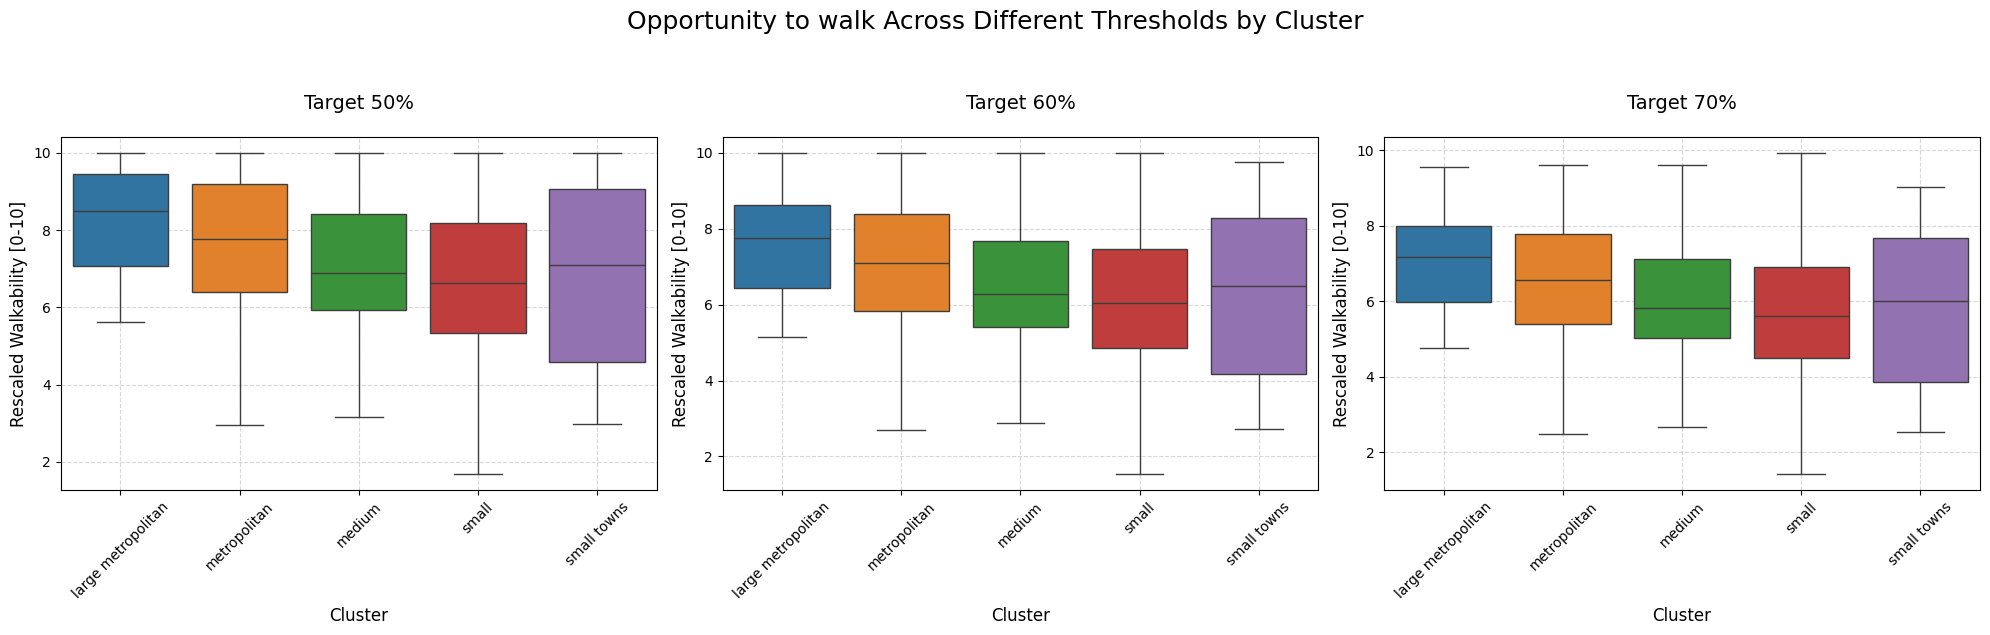

In [13]:
# Box plot for Opportunity to Walk Score Across Different Thresholds by Cluster
# Define colors for each cluster
cluster_colors = {
    'large metropolitan': '#1f77b4',  # Blue
    'metropolitan': '#ff7f0e',       # Orange
    'medium': '#2ca02c',             # Green
    'small': '#d62728',              # Red
    'small towns': '#9467bd'         # Purple
}
# Import clusters from utility.py
from utility import clusters
# Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # Adjusted for three boxplots

# Metrics and titles
metrics = [f'rescaled_city_{targets[0]}', f'rescaled_city_{targets[1]}', f'rescaled_city_{targets[2]}']
plot_titles = [f'Target {MAX_alls[0]}%', f'Target {MAX_alls[1]}%', f'Target {MAX_alls[2]}%']

# Plot boxplots using seaborn with custom colors
for idx, (metric, title) in enumerate(zip(metrics, plot_titles)):
    sns.boxplot(
        data=df,
        x='cluster',
        y=metric,
        ax=axes[idx],
        palette=cluster_colors  # Apply cluster-specific colors
    )
    axes[idx].set_title(title, pad=20, fontsize=14)
    axes[idx].set_xlabel('Cluster', fontsize=12)
    axes[idx].set_ylabel('Rescaled Walkability [0-10]', fontsize=12)
    axes[idx].grid(True, linestyle='--', alpha=0.5)
    axes[idx].tick_params(axis='x', rotation=45)

# Overall title
fig.suptitle('Opportunity to walk Across Different Thresholds by Cluster', y=1.05, fontsize=18)

# Adjust layout
plt.tight_layout()
plt.savefig('plots/indicators/SA_walk_target.png', dpi=300, bbox_inches='tight')
# Show plot
plt.show()


### Opportunity to cycle

In [14]:
"""
Calculate the opportunity to cycle indicator for each city at 250m resolution and city level
Columns of df_cycl:
- gid: Unique identifier for each row.
- pop_final: Population count.
- urau_code: Unique identifier for each urban area.
- urau_name: Name of the urban area.
- cluster: Cluster to which the urban area belongs.
- val_grid: Numeric values containing % cycling infrastructure.
"""
df = pd.read_csv(f'DATA/data/df_cycl.csv')
MIN_all = 0
MAX_alls = [15,25,35]
for MAX_all in MAX_alls:
    for cluster in clusters:

        df2 = df[df.cluster == cluster]
        df2 = df2.copy()
        #City -- POPULATION WEIGHTED OPTIONS 
        df3 = (df2.groupby('urau_code').apply(lambda x: (x['pop_final'] * x['val_grid']).sum()) / 
                df2.groupby('urau_code')['pop_final'].sum()).reset_index(name='val_city').merge(df2, 
                                                                                                on='urau_code', how='inner')

        df3 = df3.drop_duplicates(subset=['urau_code'])
        df3 = df3.copy()
        df3[f'rescaled_city_{MAX_all}'] = df3['val_city'].apply(
            lambda x: 10 if x > MAX_all else (np.sqrt(x) / np.sqrt(MAX_all)) * 10)   
        df3 = df3[['gid','urau_code','urau_name', 'pop_final', 'val_city', f'rescaled_city_{MAX_all}','cluster']]
        df3.to_csv(f'DATA/new_data\\{cluster}\\city\Sustainable Transportation_Opportunity to cycle_{MAX_all}.csv', index=False) 


In [15]:
# Load indicator data created in the 3_indicators_analysis.py script
# Urban Design Domain - Grid Level

dfs = []
# Exclude Compactness indicator whic is not available at grid level
indicator_city =  indicators[5]
domain = domains[1]
scale = 'city'
targets = MAX_alls
for target in targets:
    dfs = []
    # Read Permeability indicator
    for cluster in clusters:
        folder_path = f'DATA\\new_data\\{cluster}\\{scale}'
        filename = f'{domain}_{indicator_city}_{target}.csv'
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        df['indicator'] = indicator_city
        df['domain'] = domain
        dfs.append(df)
        #print(f'{cluster} and {indicator}:{len(df.urau_code.unique())}')
    if target == targets[0]:
        df1 = pd.concat(dfs, ignore_index=True)
    if target == targets[1]:
        df2 = pd.concat(dfs, ignore_index=True)   
    else:
        df3 = pd.concat(dfs, ignore_index=True)            

df0 = pd.merge(df1[['gid','urau_code',f'rescaled_city_{targets[0]}','cluster']],
               df2[['gid','urau_code',f'rescaled_city_{targets[1]}']],
              on = ['gid','urau_code'], how = 'inner')
df = pd.merge(df0,df3[['gid','urau_code',f'rescaled_city_{targets[2]}']],
              on = ['gid','urau_code'], how = 'inner')

In [16]:
percentile_95 = df1['val_city'].quantile(0.95)
print(f"The 95th percentile of val_city is: {percentile_95}")

The 95th percentile of val_city is: 12.954065404771484


C:\Users\fmontana\AppData\Local\Temp\ipykernel_25432\405502216.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\fmontana\AppData\Local\Temp\ipykernel_25432\405502216.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\fmontana\AppData\Local\Temp\ipykernel_25432\405502216.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


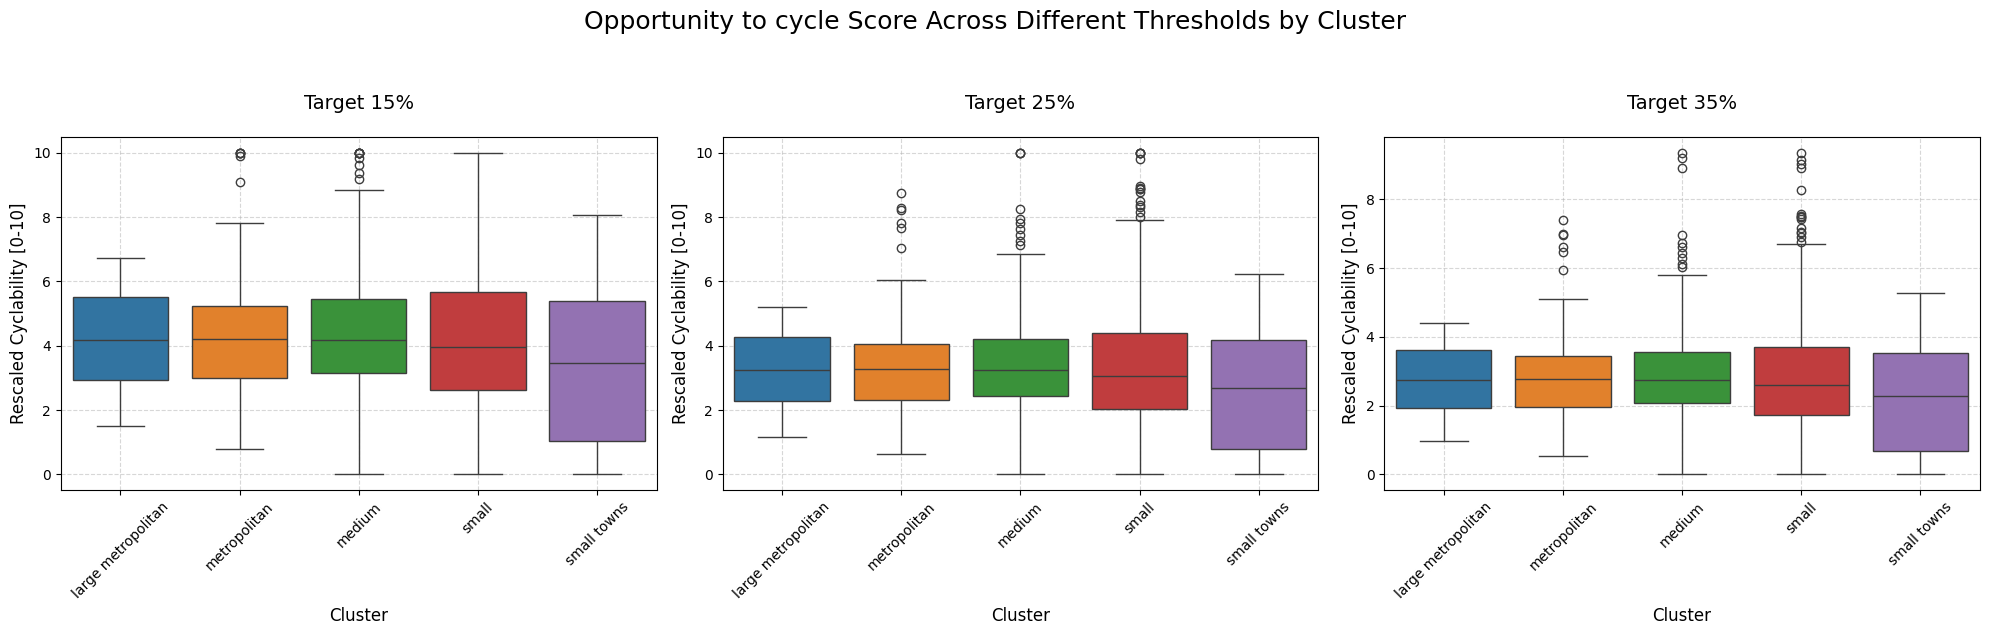

In [17]:
# Box plot for Opportunity to Walk Score Across Different Thresholds by Cluster
# Define colors for each cluster
cluster_colors = {
    'large metropolitan': '#1f77b4',  # Blue
    'metropolitan': '#ff7f0e',       # Orange
    'medium': '#2ca02c',             # Green
    'small': '#d62728',              # Red
    'small towns': '#9467bd'         # Purple
}
# Import clusters from utility.py
from utility import clusters

# Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # Adjusted for three boxplots

# Metrics and titles
metrics = [f'rescaled_city_{targets[0]}', f'rescaled_city_{targets[1]}', f'rescaled_city_{targets[2]}']
plot_titles = [f'Target {MAX_alls[0]}%', f'Target {MAX_alls[1]}%', f'Target {MAX_alls[2]}%']

# Plot boxplots using seaborn with custom colors
for idx, (metric, title) in enumerate(zip(metrics, plot_titles)):
    sns.boxplot(
        data=df,
        x='cluster',
        y=metric,
        ax=axes[idx],
        palette=cluster_colors  # Apply cluster-specific colors
    )
    axes[idx].set_title(title, pad=20, fontsize=14)
    axes[idx].set_xlabel('Cluster', fontsize=12)
    axes[idx].set_ylabel('Rescaled Cyclability [0-10]', fontsize=12)
    axes[idx].grid(True, linestyle='--', alpha=0.5)
    axes[idx].tick_params(axis='x', rotation=45)

# Overall title
fig.suptitle('Opportunity to cycle Score Across Different Thresholds by Cluster', y=1.05, fontsize=18)

# Adjust layout
plt.tight_layout()
plt.savefig('plots/indicators/SA_cycl_target.png', dpi=300, bbox_inches='tight')
# Show plot
plt.show()


### PM2.5 and NO2

In [18]:
pm = pd.read_csv('DATA\\external_dataset\\PM25_measurements_airbase.csv')
pm = pm.rename(columns={'URAU_CODE': 'urau_code'})
pm = pm.rename(columns={'URAU_NAME': 'urau_name'})
pm.rename(columns={'concentration':'concentration_pm'}, inplace = True)

no2 = pd.read_csv('DATA\\external_dataset\\NO2_measurements_airbase.csv')
no2 = no2.rename(columns={'URAU_CODE': 'urau_code'})
no2 = no2.rename(columns={'URAU_NAME': 'urau_name'})
no2.rename(columns={'concentration':'concentration_no2'}, inplace = True)
airbase = pd.merge(pm, no2[['concentration_no2', 'urau_code']], on='urau_code', how='inner')

In [19]:
# Calculate correlation and p-value
df1 = pd.read_csv('DATA\\data\\df_ap.csv')
# compute city level
df1['PMcity'] = df1.groupby('urau_code')['PMmean'].transform('mean')

df1['NO2city'] = df1.groupby('urau_code')['NO2mean'].transform('mean')

df1 = df1.drop_duplicates(subset=['urau_code'])


In [20]:
col1 = 'PMcity'
col2 = 'NO2city'

col11 = 'concentration_pm'
col22 = 'concentration_no2'


merged_df = pd.merge(df1, airbase[['urau_code',col11,col22]], on=['urau_code'], how='inner')

In [21]:
# Spearman correlation and p-value 
spearman_corr, spearman_p = stats.spearmanr(merged_df[col1], merged_df[col11])
spearman_corr2, spearman_p2 = stats.spearmanr(merged_df[col2], merged_df[col22])

# Create summary
print("Correlation Analysis:")
print(f"- Spearman correlation pm: {spearman_corr:.2f}")
print(f"- Spearman correlation no2: {spearman_corr2:.2f}")

Correlation Analysis:
- Spearman correlation pm: 0.73
- Spearman correlation no2: 0.62


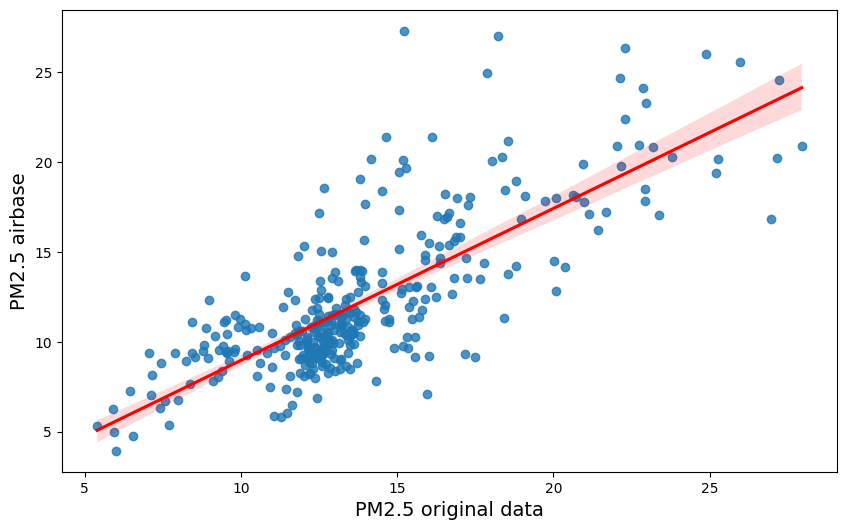

In [22]:
# Scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=merged_df[col1], y=merged_df[col11], ci=95, line_kws={"color": "red"})

# Add titles and labels
#plt.title("Scatter Plot with Regression Line", fontsize=16)
plt.xlabel("PM2.5 original data", fontsize=14)
plt.ylabel("PM2.5 airbase", fontsize=14)
plt.savefig('plots\\data\\pm.png')
# Show the plot
plt.show()

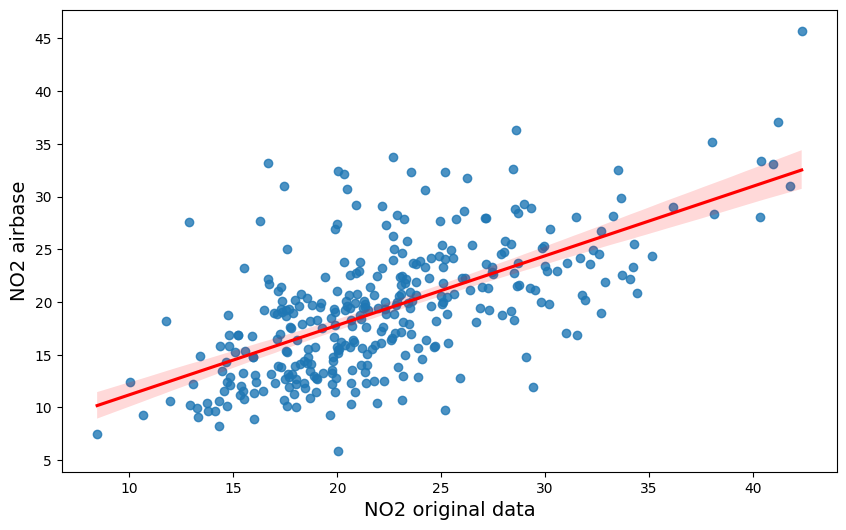

In [23]:
# Scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=merged_df[col2], y=merged_df[col22], ci=95, line_kws={"color": "red"})

# Add titles and labels
#plt.title("Scatter Plot with Regression Line", fontsize=16)
plt.xlabel("NO2 original data", fontsize=14)
plt.ylabel("NO2 airbase", fontsize=14)
plt.savefig('plots\\data\\no2.png')

# Show the plot
plt.show()